# <center><font color=#76B900 size="+3"><b>**NVIDIA cuOpt Basics (TSP, VRP)**</b></font></center>
---

**Learning Objectives:**
- Introduction to the cuOpt Python API
- Modeling of a Traveling Salesman Problem (TSP)
- Modeling of a Vehicle Routing Problem (VRP)
- Introduction to constraints

You have just started a new professional services company.  You have attracted a number of customers at various locations across the city and want to service these accounts as quickly as possible. In order to achieve this goal you want to minimize the time you spend traveling between locations (time spent not directly serving customers).  As the founder and sole employee it is your responsibility to service all of these accounts. 

This is a standard TSP problem:

*Given a list of locations to visit and distance between each location, what is the shortest possible route that visits each location exactly once and returns to the origin/depot.*

<centre><img src=https://upload.wikimedia.org/wikipedia/commons/thumb/1/11/GLPK_solution_of_a_travelling_salesman_problem.svg/220px-GLPK_solution_of_a_travelling_salesman_problem.svg.png> </centre>

**Let's consider the following TSP problem:**
- 8 Locations:
    - 1 Depot (e.g. Office or Warehouse)
    - 7 (Clients/Customer)
- 1 Vehicle

In [1]:
from cuopt import routing
import cudf
import pandas as pd
from scipy.spatial import distance
import helper_function.helper_map as helper_map

## Problem Definition

In [2]:
location_names       = [ "Depot",   "A",    "B",    "C",    "D",    "E",    "F",    "G"  ]
location_coordinates = [ [4, 4],    [1, 3], [8, 1], [2, 1], [6, 7], [0, 2], [7, 6], [5, 3] ]

n_locations = len(location_coordinates)
n_vehicles = 1

location_coordinates_df = pd.DataFrame(location_coordinates, columns=['xcord', 'ycord'], index=location_names)

location_coordinates_df

,xcord,ycord
Depot,4,4
A,1,3
B,8,1
C,2,1
D,6,7
E,0,2
F,7,6
G,5,3


### Visualize Depot and Destinations

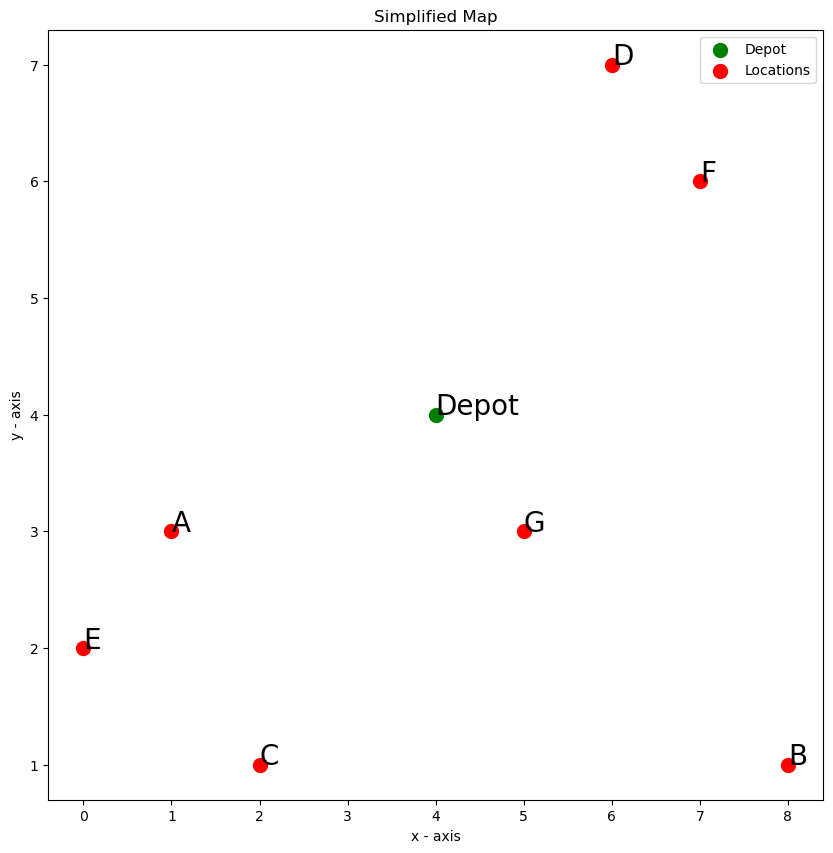

In [3]:
helper_map.gen_plot(location_coordinates_df).show()

The **cost matrix** models the cost between each pair of locations.  It is used by NVIDIA cuOpt to compute the cost of traveling from any location to any other.  Here we are going to specify that distance traveled is the cost we are looking to minimize. 

Let's create a distance based cost matrix (called `distance_matrix`)from the location coordinates dataframe, and let the distance between locations be measured by a `euclidean` metric. This will result in a symmetric distance matrix [ distance(A, B) == distance(B, A) ] which is an ideal case. However, in general NVIDIA cuOpt also supports asymmetric matrices which is especially useful when dealing with real-world problems.

In [4]:
distance_matrix = distance.cdist(location_coordinates_df.values, location_coordinates_df.values, "euclidean")

# Let's create a dataframe of this matrix
distance_matrix  = cudf.DataFrame(distance_matrix, 
                                  index=location_coordinates_df.index, 
                                  columns=location_coordinates_df.index)

distance_matrix

,Depot,A,B,C,D,E,F,G
Depot,0.000000,3.162278,5.000000,3.605551,3.605551,4.472136,3.605551,1.414214
A,3.162278,0.000000,7.280110,2.236068,6.403124,1.414214,6.708204,4.000000
B,5.000000,7.280110,0.000000,6.000000,6.324555,8.062258,5.099020,3.605551
C,3.605551,2.236068,6.000000,0.000000,7.211103,2.236068,7.071068,3.605551
D,3.605551,6.403124,6.324555,7.211103,0.000000,7.810250,1.414214,4.123106
E,4.472136,1.414214,8.062258,2.236068,7.810250,0.000000,8.062258,5.099020
F,3.605551,6.708204,5.099020,7.071068,1.414214,8.062258,0.000000,3.605551
G,1.414214,4.000000,3.605551,3.605551,4.123106,5.099020,3.605551,0.000000


<br>

## Create Data-Model
---
To create a basic Data model the following are required:
 - Number of locations 
 - Number of vehicles in the fleet
 - Cost matrix

In [5]:
data_model = routing.DataModel(n_locations, n_vehicles)
data_model.add_cost_matrix(distance_matrix)

<br>

## Create Solver Instance
---
The solver instance will take the data-model and return an optimized route plan. Additional configuration options are available to further customize solver behavior including: 
- The number of parallel agents (climbers) examining the solution search space
- The maximum time allotted to find a solution
- The minimum number of vehicles to be used
- and more

In [6]:
solver_settings_settings = routing.SolverSettings()
# set number of climbers that will try to search for an optimal path parallely
solver_settings_settings.set_number_of_climbers(64)
# solver_settings will run for given time limit and it will fail if needs more time
solver_settings_settings.set_time_limit(0.01)
routing_solution = routing.Solve(data_model, solver_settings_settings)
if routing_solution.get_status() == 0:
    print("Solution Found")
else:
    print("No Solution Found")

Solution Found


<br>

## TSP Results
---

In [7]:
if routing_solution.get_status() == 0:
    print("Cost for the routing in distance: ", routing_solution.final_cost)
    print("Vehicle count to complete routing: ", routing_solution.vehicle_count)
    helper_map.show_vehicle_routes(routing_solution.route, location_names)
    routing_solution.route
else:
    print("NVIDIA cuOpt Failed to find a solution with status : ", routing_solution.get_status())

Cost for the routing in distance:  24.142446517944336
Vehicle count to complete routing:  1
For vehicle - 0 route is: 

Depot->A->E->C->G->B->F->D->Depot




### Visualize Route Plan

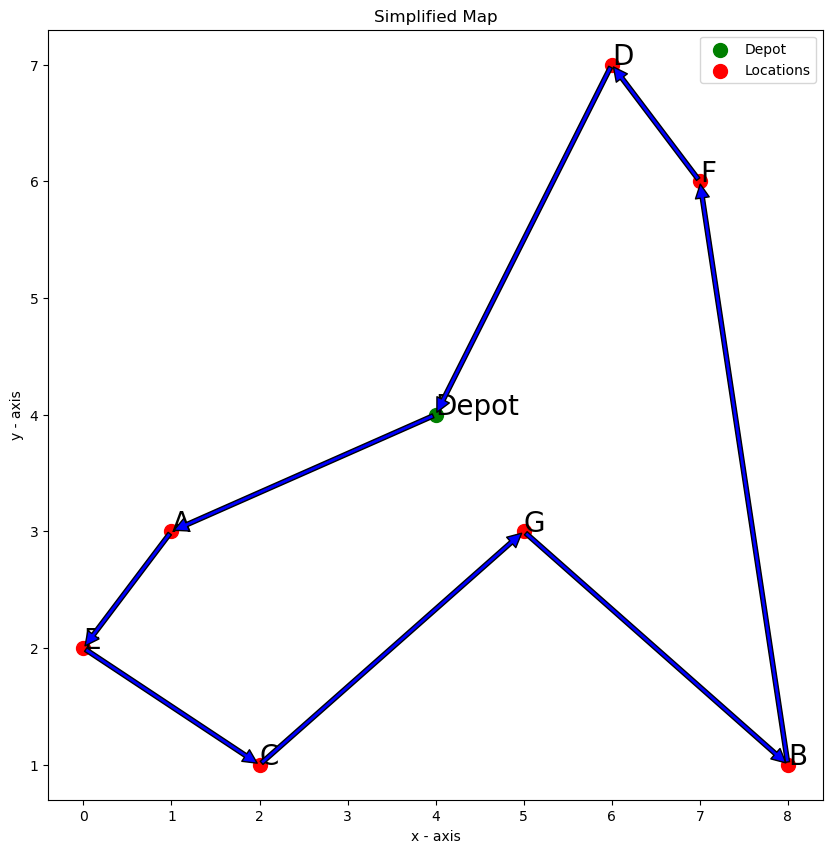

In [8]:
tsp_route_color = ['blue']
helper_map.map_vehicle_routes(location_coordinates_df, routing_solution.route, tsp_route_color).show()

This illustrates the shortest path found by NVIDIA cuOpt to service all locations while minimizing the overall distance traveled.



# VRP
---
Congratulations, your customers are happy with the service you provide.  Naturally, this has led to increased demand for your service and you need to add additional staff to support this new demand.  You would like to understand the benefit of hiring 3 additional staff.

This is similar to TSP, except here we will route an entire fleet of vehicles to optimally visit each location once and return to the depot.

<centre><img src=https://upload.wikimedia.org/wikipedia/commons/2/2b/Figure_illustrating_the_vehicle_routing_problem.png> </centre>


We can constrain the solver to leverage your expanded fleet by setting the minimum number of vehicles equal to our new fleet size (4 vehicles are now available).

In [9]:
n_vehicles_expanded = 4
vehicle_colors = ["blue", "white", "green", "pink"] # Used to identify differnt vehicle 

# create a new data model with the expanded fleet size
data_model = routing.DataModel(n_locations, n_vehicles_expanded)
data_model.add_cost_matrix(distance_matrix)
data_model.set_min_vehicles(n_vehicles_expanded)


# create a new solver_settings instance based on the revised data model
solver_settings_settings = routing.SolverSettings()
solver_settings_settings.set_number_of_climbers(64)
solver_settings_settings.set_time_limit(0.01)


routing_solution = routing.Solve(data_model, solver_settings_settings)

if routing_solution.get_status() == 0:
    print("Solution Found")
else:
    print("No Solution Found")

Solution Found


<br>

## VRP Results
---

In [10]:
if routing_solution.get_status() == 0:
    print("Cost for the routing in distance: ", routing_solution.final_cost)
    print("Vehicle count to complete routing: ", routing_solution.vehicle_count)
    helper_map.show_vehicle_routes(routing_solution.route, location_names)
    routing_solution.route
else:
    print("NVIDIA cuOpt Failed to find a solution with status : ", routing_solution.get_status())

Cost for the routing in distance:  36.2545280456543
Vehicle count to complete routing:  4
For vehicle - 0 route is: 

Depot->F->Depot


For vehicle - 1 route is: 

Depot->D->Depot


For vehicle - 2 route is: 

Depot->B->Depot


For vehicle - 3 route is: 

Depot->G->C->E->A->Depot




### Visualize Route Plan

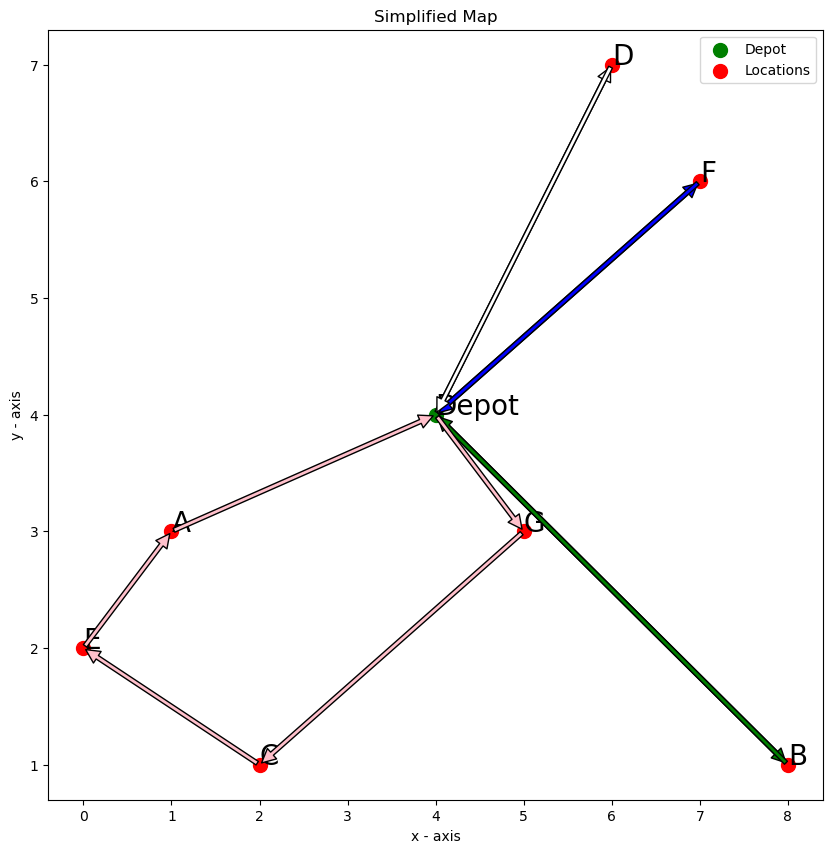

In [11]:
helper_map.map_vehicle_routes(location_coordinates_df, routing_solution.route, vehicle_colors).show()

While this is an interesting solution, **it is perhaps not what we are looking for**.  We want to hire additional staff to distribute the workload. To achieve this, we can add a **constraint** on the maximum number of stops a given vehicle can perform depending on the number of stops and the number of available vehicles.

In [12]:
data_model = routing.DataModel(n_locations, n_vehicles_expanded)
data_model.add_cost_matrix(distance_matrix)
data_model.set_min_vehicles(n_vehicles_expanded)

# Here we add the constraint limit the number of stops a single vehicle can make
stop_demand_per_location = cudf.Series([0] + [1 for _ in range(n_locations-1)])
stops_per_vehicle = cudf.Series([n_locations//n_vehicles_expanded for _ in range(n_vehicles_expanded)])
data_model.add_capacity_dimension("Number_of_Stops", stop_demand_per_location, stops_per_vehicle)

print("stop_demand_per_location: ",stop_demand_per_location.to_arrow().to_pylist()) 
print("stops_per_vehicle: ", stops_per_vehicle.to_arrow().to_pylist())

# create a new solver_settings instance based on the revised data model
solver_settings_settings = routing.SolverSettings()
solver_settings_settings.set_number_of_climbers(64)
solver_settings_settings.set_time_limit(0.01)

routing_solution = routing.Solve(data_model, solver_settings_settings)
    
    
if routing_solution.get_status() == 0:
    print("\nSolution Found")
    print("Cost for the routing in distance: ", routing_solution.final_cost)
    print("Vehicle count to complete routing: ", routing_solution.vehicle_count)
    helper_map.show_vehicle_routes(routing_solution.route, location_names)
    routing_solution.route
else:
    print("NVIDIA cuOpt Failed to find a solution with status : ", routing_solution.get_status())

stop_demand_per_location:  [0, 1, 1, 1, 1, 1, 1, 1]
stops_per_vehicle:  [2, 2, 2, 2]

Solution Found
Cost for the routing in distance:  34.90481185913086
Vehicle count to complete routing:  4
For vehicle - 0 route is: 

Depot->C->Depot


For vehicle - 1 route is: 

Depot->D->F->Depot


For vehicle - 2 route is: 

Depot->E->A->Depot


For vehicle - 3 route is: 

Depot->G->B->Depot




### Visualize the New Route Plan

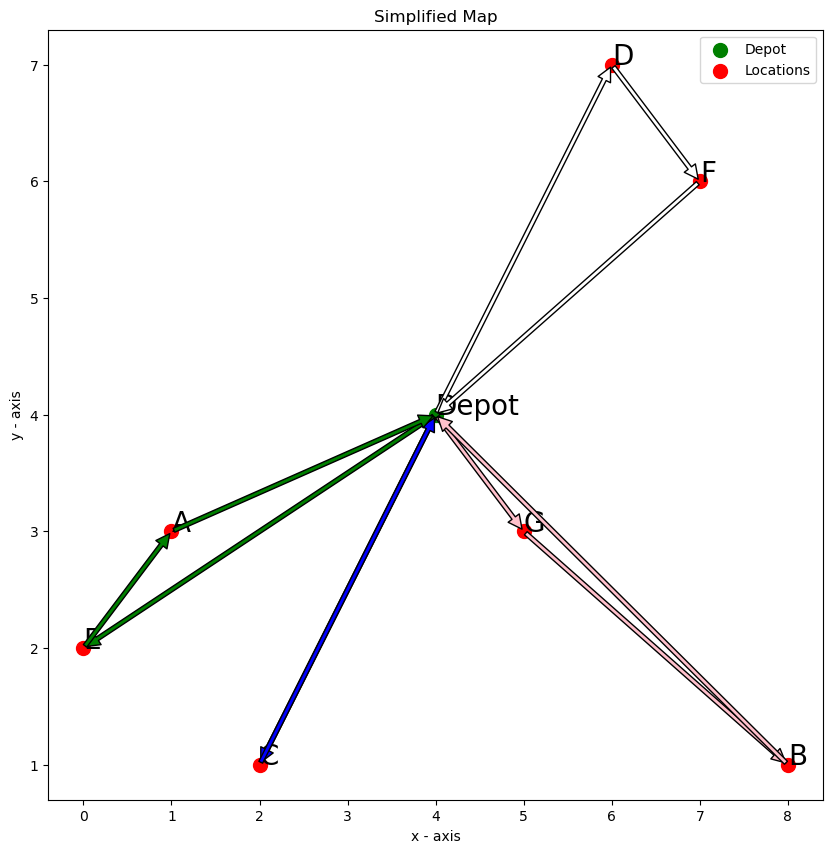

In [13]:
helper_map.map_vehicle_routes(location_coordinates_df, routing_solution.route, vehicle_colors).show()

We now have the shortest solution where the work load is more evenly distributed among available vehicles

## Dynamic Re-optimization

You decide to go ahead with adding additional staff. On a particular day, 1 of your new staff members calls in sick.  We can quickly generate a new routing solution accounting for the reduced staff.

stop_demand_per_location:  [0, 1, 1, 1, 1, 1, 1, 1]
stops_per_vehicle:  [3, 3, 3]

Solution Found
Cost for the routing in distance:  28.36532211303711
Vehicle count to complete routing:  3
For vehicle - 0 route is: 

Depot->A->E->C->Depot


For vehicle - 1 route is: 

Depot->G->Depot


For vehicle - 2 route is: 

Depot->D->F->B->Depot




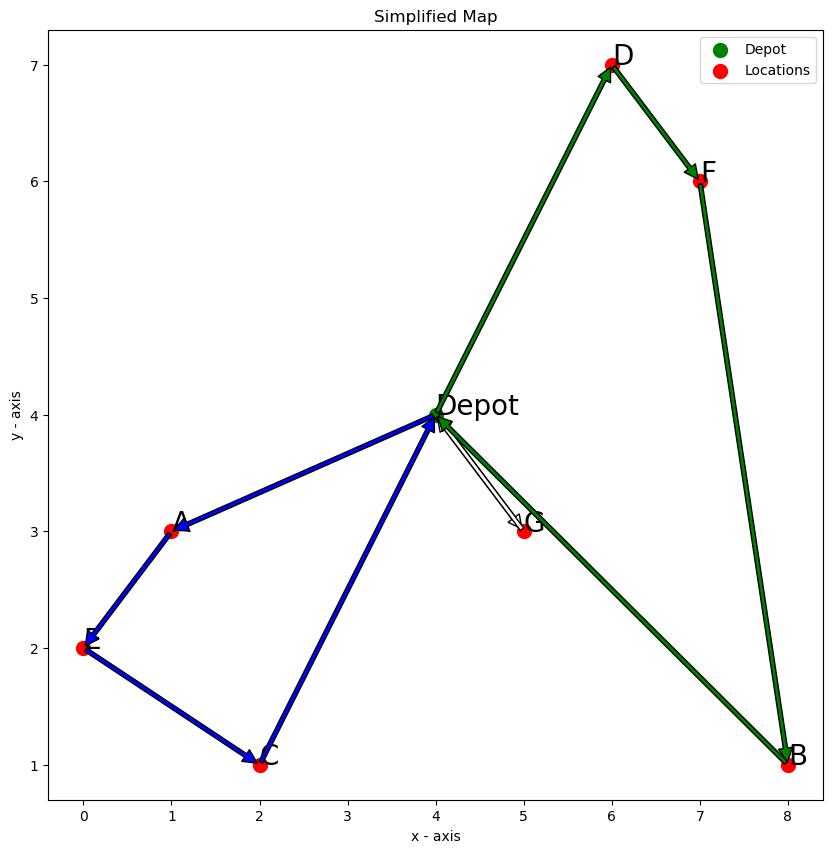

In [14]:
reduced_staff = n_vehicles_expanded-1
data_model = routing.DataModel(n_locations, reduced_staff)
data_model.add_cost_matrix(distance_matrix)

# Here we add the constraint limit the number of stops a single vehicle can make
stop_demand_per_location = cudf.Series([0] + [1 for _ in range(n_locations-1)])
stops_per_vehicle = cudf.Series([(n_locations//reduced_staff)+1 for _ in range(reduced_staff)])
data_model.add_capacity_dimension("Number_of_Stops", stop_demand_per_location, stops_per_vehicle)
data_model.set_min_vehicles(reduced_staff)
print("stop_demand_per_location: ",stop_demand_per_location.to_arrow().to_pylist()) 
print("stops_per_vehicle: ", stops_per_vehicle.to_arrow().to_pylist())

# create a new solver_settings instance based on the revised data model
solver_settings_settings = routing.SolverSettings()
solver_settings_settings.set_number_of_climbers(64)
solver_settings_settings.set_time_limit(0.01)

routing_solution = routing.Solve(data_model, solver_settings_settings)    
    
if routing_solution.get_status() == 0:
    print("\nSolution Found")
    print("Cost for the routing in distance: ", routing_solution.final_cost)
    print("Vehicle count to complete routing: ", routing_solution.vehicle_count)
    helper_map.show_vehicle_routes(routing_solution.route, location_names)
    routing_solution.route
else:
    print("NVIDIA cuOpt Failed to find a solution with status : ", routing_solution.get_status())
    
helper_map.map_vehicle_routes(location_coordinates_df, routing_solution.route, vehicle_colors).show()

Though shown here on a toy problem instance for clarity, the ability to respond to the dynamic nature of real world problems is perhaps the key feature of NVIDIA cuOpt and is a benefit that scales to problems with 1000s of locations and complex constraints. The true potential NVIDIA cuOpt speed and accuracy can be observed in the [optional notebook](./05_cvrptw_homberger_cuopt.ipynb) where we examine the performance of NVIDIA cuOpt on the largest instance size currently available in a public benchmark.

In [15]:
import IPython
app = IPython.Application.instance()
app.kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}

## What's Next?

Add more real-world constraints including:
- **Vehicles with limited capacity**
- **Deliveries expected in particular time windows**
- **Multiple deliveries to same location**
- **Vehicle availability** 


#### Lets try **CVRPTW** next, [please click to continue](./03_cvrptw_cuopt.ipynb)

<center><a href="https://www.nvidia.com/dli"> <img src="images/DLI_Header.png" alt="Header" style="width: 400px;"/> </a></center>